# 0.0 Imports

In [61]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt

from scipy import stats
from sklearn import preprocessing

## 0.1 Helper Functions

In [102]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [15, 10]
#     plt.rcParams['font.size'] = 11
    
#     #display( HTML( '<style>.container { width:100% !important; }</style>') )
#     #display(HTML("<style>.jp-Cell { width: 60% !important; }</style>"))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
#     sns.set()
# jupyter_settings()


def calculate_pct(data, key, att1, att2 = ''):
    # calculates 'att1' and 'att2' frequency as percentage of 'key'

    if att2 == '': 
        data = data[[key, att1]].groupby(att1).count().reset_index()

        data.rename(columns={key:'count'}, inplace=True) # rename column

        # total count in percentage form
        data['pct'] = 100 * data['count'] / (data['count'].sum())

    else:
        # splitting dataset by att1 and att2 then counting keys within each group
        data = data[[key, att1, att2]].groupby([att1, att2]).count().reset_index()
       # data = data.reset_index(level=[att1, att2]) # transform gender and response index keys into columns
        data.rename(columns={key:'count'}, inplace=True) # rename column
        
        data['pct'] = 100 * data['count'] / (data.groupby(att1)['count'].transform('sum'))

    return data

def cramers_v (x,y):

    # making a cross-tabulation table (contingency table) that shows the frequency of two groups of data
    ct = pd.crosstab(x,y).values # transforms table to array object (easy to perform some operations, eg. sum, dimensions)
    
    totals = ct.sum() # sum all the values of the cross-tabulation table (now an array)
    rows, cols = ct.shape # get array's dimensions (index, rows) and number of elements in each dimension (cols)

    chi2 = stats.chi2_contingency(ct)[0] # returns a list with chi2, p-value, degree of freedom and expected values. We only want the first element (chi2).


    # Bias Correction - source: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    chi2_corr = max(0, (chi2/totals - ( (cols-1)*(rows-1) )/(totals-1) ) )

    cols_corr = cols - pow( (cols-1),2 )/(totals-1)
    rows_corr = rows - pow( (rows-1),2 )/(totals-1)

    v = np.sqrt( chi2_corr/min((cols_corr - 1), (rows_corr - 1) ) )

    return v

# 1.0 Load data

In [63]:
path = str(Path.cwd().parents[0] / "data" / "raw")
path = path + '/' + 'df_raw.csv'

df = pd.read_csv(path)

# 2.0 Data Description

In [64]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.1 Data Dimensions

In [65]:
df_dim = df.copy()

In [66]:
df_dim.shape

(381109, 12)

In [67]:
df_dim.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [68]:
df_dim.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.2 Change Types

In [69]:
# region_code to int64
df_dim['region_code'] = df_dim['region_code'].astype('int64')

# policy_sales_channel to int64
df_dim['policy_sales_channel'] = df_dim['policy_sales_channel'].astype('int64')

# vehicle_age:
#   <1 : 'New'
#   1-2 : 'Average'
#   >2 : 'Used'
# WARNING: dont run this segment more than once, or all rows in the column 'vehicle_age' will be = 'Used' 
df_dim['vehicle_age'] = df_dim['vehicle_age'].apply(lambda x: 'New' if x == '< 1 Year' else
                                            'Average' if x == '1-2 Year' else
                                            'Used')

# WARNING: dont run this segment more than once, or all rows in the columns will have the value after 'else' (No) 
df_dim['driving_license'] = df_dim['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
df_dim['previously_insured'] = df_dim['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

## 2.3 Check and Fill NAs

In [70]:
# dropna() function removes rows (by default) which at least one NA value
# So, if at least one row was removed, then we have at least one NA value on this dataset
if (df_dim.dropna().shape == df_dim.shape):
    print('Not a single NA on this dataset')

else:
    print('There is at least one NA value on this dataset')

Not a single NA on this dataset


In [71]:
# removing duplicated IDs
df_dim['id'] = df_dim['id'].drop_duplicates

## 2.4 Descriptive Statistics

In [93]:
df_desc = df_dim.copy()

### 2.4.1 Separating Numerical and Categorical Attributes

In [73]:
# numerical attributes
aux = df_desc.applymap(np.isreal) # All numeric values will be set as True. Non-numeric will be set as 'False'
num_att = df_desc[aux] # copy all numeric values. Non-numeric will be set as 'NaN'
num_att = num_att.dropna(axis=1) # drop entire column if it contains any NA value

# categorical attributes
cat_att = df_desc[~ aux] # copy all non-numeric values (see the negation ~ signal). Numeric will be set as 'NaN'
cat_att = cat_att.dropna(axis=1) # drop entire column if it contains any NA value

### 2.4.2 Numerical Attributes Metrics

In [74]:
num_att = num_att.drop(columns = 'id') # it is not useful to know metrics of this column

# central tendency
mean = pd.DataFrame(num_att.apply(np.mean)).T
median = pd.DataFrame(num_att.apply(np.median)).T

# dispersion metrics
std = pd.DataFrame(num_att.apply(np.std)).T
min_ = pd.DataFrame(num_att.min()).T
max_ = pd.DataFrame(num_att.max()).T
range = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenate
metrics = pd.concat([mean, median, std, min_, max_, range, skew, kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'avg', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [75]:
metrics

,attributes,avg,median,std,min,max,range,skew,kurtosis
0,age,38.822584,36.0,15.511591,20.0,85.0,65.0,0.672539,-0.565655
1,region_code,26.388807,28.0,13.229871,0.0,52.0,52.0,-0.115266,-0.867857
2,policy_sales_channel,112.034295,133.0,54.203924,1.0,163.0,162.0,-0.900008,-0.970810
3,annual_premium,30564.389581,31669.0,17213.132474,2630.0,540165.0,537535.0,1.766087,34.004569
4,vintage,154.347397,154.0,83.671194,10.0,299.0,289.0,0.003030,-1.200688
5,response,0.122563,0.0,0.327935,0.0,1.0,1.0,2.301906,3.298788


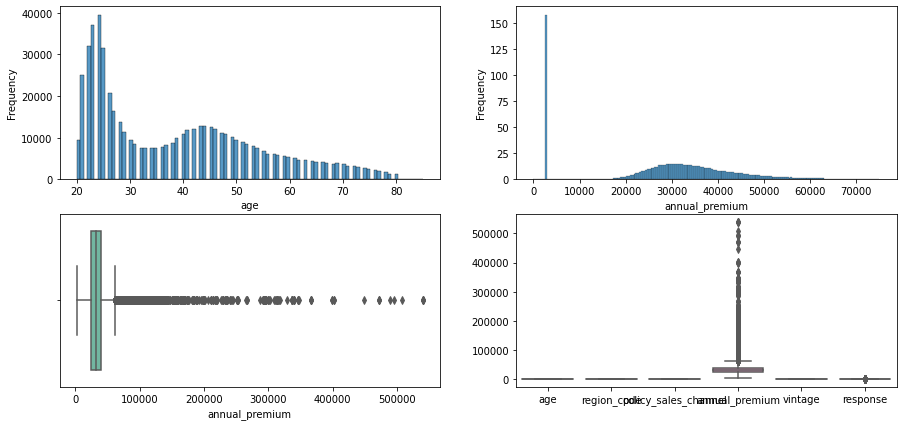

In [76]:
# grid and image dimensions
fig, ax = plt.subplots(figsize=(15, 7), nrows = 2, ncols = 2)

# plots
plt.subplot(2, 2, 1)
sns.histplot(data = num_att['age'], stat = 'frequency');

plt.subplot(2, 2, 2)
sns.histplot(data = num_att['annual_premium'], stat = 'frequency', binrange = [0, 75000]); # binrange based on median value

plt.subplot(2, 2, 3)
sns.boxplot(x = 'annual_premium', orient = 'h', palette = 'Set2', data = num_att);

plt.subplot(2, 2, 4)
sns.boxplot(palette = 'Set2', data = num_att);

plt.show()

### 2.4.3 Categorical Attributes

In [77]:
# how many unique categories
cat_att.apply(lambda x: x.unique().shape[0])

gender                2
driving_license       2
vehicle_age           3
vehicle_damage        2
previously_insured    2
dtype: int64

#### 2.4.3.1 Response by Gender

In [94]:
# ONLY RUN ONCE
# replaces 1/0 values by Yes/No
df_desc['response'] = df_desc['response'].apply(lambda x: 'Yes' if x == 1 else 'No')

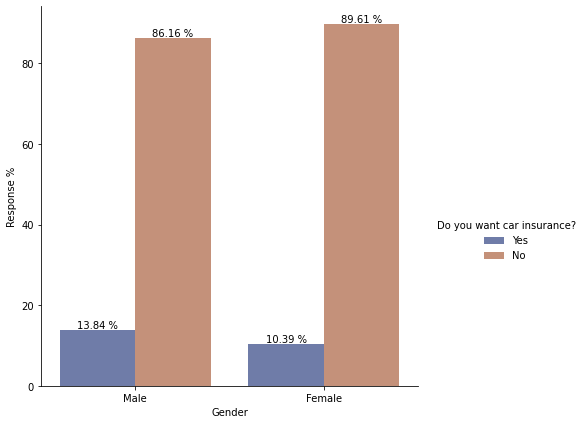

In [103]:
# calculates percentage
response_count = calculate_pct(df_desc, 'id', 'gender', 'response')

# draw a nested barplot by response and gender
g = sns.catplot(
    data = response_count,
    kind = 'bar',
    x = 'gender',
    y = 'pct',
    order = ['Male', 'Female'], # categories plot order
    hue = 'response',
    hue_order = ['Yes', 'No'], # bars plot order
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("Gender", "Response %")
#g.legend.set_title("Response")
sns.move_legend(g, loc='upper left', bbox_to_anchor=(0.90, 0.5), title='Do you want car insurance?')

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')

#### 2.4.3.2 Response by Driving License

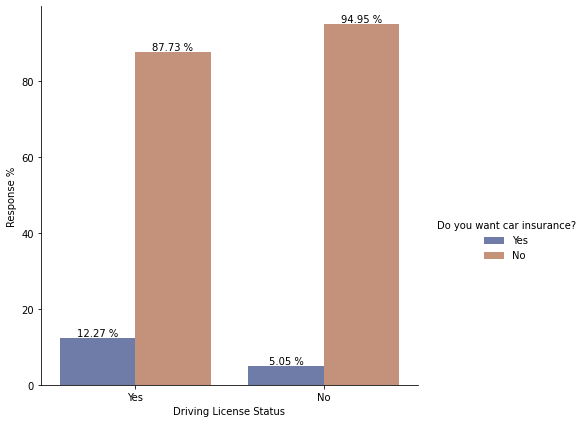

In [105]:
# calculates percentage
response_count = calculate_pct(df_desc, 'id', 'driving_license', 'response')

# draw a nested barplot by response and driving_license
g = sns.catplot(
    data = response_count,
    kind = 'bar',
    x = 'driving_license',
    y = 'pct',
    order = ['Yes', 'No'], # categories plot order
    hue = 'response',
    hue_order = ['Yes', 'No'], # bars plot order
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("Driving License Status", "Response %")
#g.legend.set_title("Response")
sns.move_legend(g, loc='upper left', bbox_to_anchor=(0.90, 0.5), title='Do you want car insurance?')

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')

#### 2.4.3.3 Response by Vehicle Age

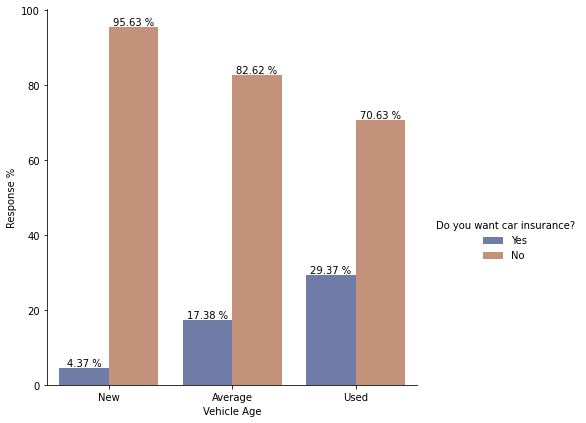

In [106]:
# calculates percentage
response_count = calculate_pct(df_desc, 'id', 'vehicle_age', 'response')

# draw a nested barplot by response and vehicle_age
g = sns.catplot(
    data = response_count,
    kind = 'bar',
    x = 'vehicle_age',
    y = 'pct',
    order = ['New', 'Average', 'Used'], # categories plot order (x-axis)
    hue = 'response',
    hue_order = ['Yes', 'No'], # bars plot order
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("Vehicle Age", "Response %")
#g.legend.set_title("Response")
sns.move_legend(g, loc='upper left', bbox_to_anchor=(0.90, 0.5), title='Do you want car insurance?')

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')

#### 2.4.3.4 Response by Vehicle Damage ocurrence

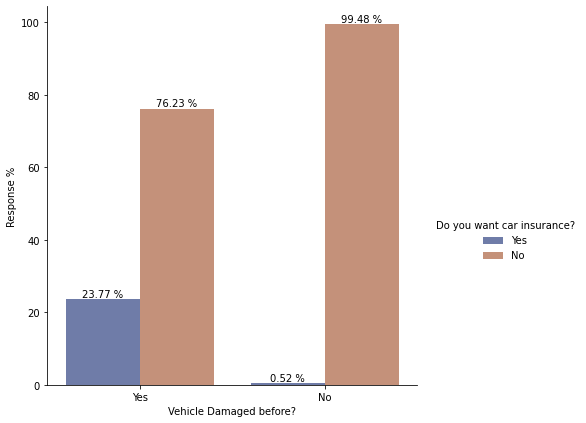

In [108]:
# calculates percentage
response_count = calculate_pct(df_desc, 'id', 'vehicle_damage', 'response')

# draw a nested barplot by response and vehicle_damage
g = sns.catplot(
    data = response_count,
    kind = 'bar',
    x = 'vehicle_damage',
    y = 'pct',
    order = ['Yes', 'No'], # categories plot order (x-axis)
    hue = 'response',
    hue_order = ['Yes', 'No'], # bars plot order
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("Vehicle Damaged before?", "Response %")
sns.move_legend(g, loc='upper left', bbox_to_anchor=(0.90, 0.5), title='Do you want car insurance?')

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')

#### 2.4.3.5 Response by Previously Insured status

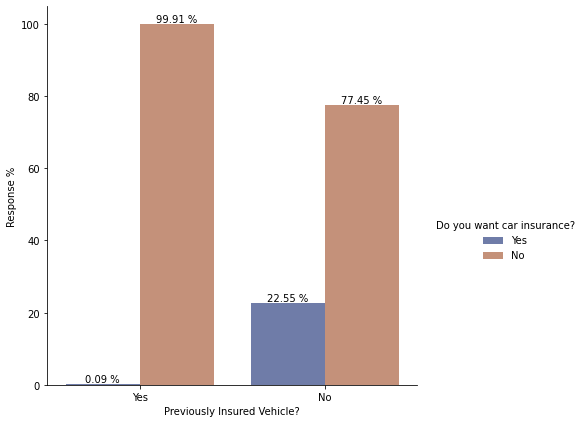

In [109]:
# calculates percentage
response_count = calculate_pct(df_desc, 'id', 'previously_insured', 'response')

# draw a nested barplot by response and previously_insured
g = sns.catplot(
    data = response_count,
    kind = 'bar',
    x = 'previously_insured',
    y = 'pct',
    order = ['Yes', 'No'], # categories plot order (x-axis)
    hue = 'response',
    hue_order = ['Yes', 'No'], # bars plot order
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("Previously Insured Vehicle?", "Response %")
sns.move_legend(g, loc='upper left', bbox_to_anchor=(0.90, 0.5), title='Do you want car insurance?')

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')

## 2.5 EDA

In [110]:
df_eda = df_desc.copy()

### 2.5.1 Univariate Analysis

#### 2.5.1.1 Response Variable
Show the frequency of the Response variable accross the dataset.

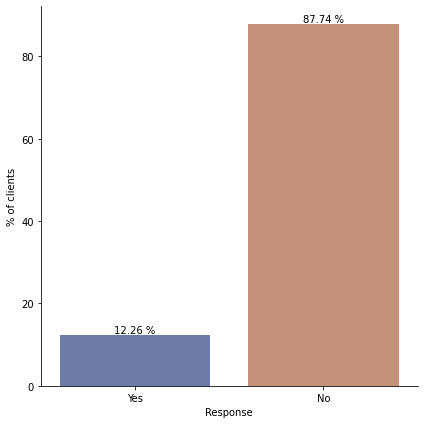

In [112]:
# response variable frequency: how many IDs responded 'Yes' or 'No'?

# calculates percentage
r_freq = calculate_pct(df_eda, 'id', 'response')

# draw a nested barplot showing response % accross the dataset
g = sns.catplot(
    data = r_freq,
    kind = 'bar',
    x = 'response',
    y = 'pct',
    order = ['Yes', 'No'], # categories plot order (x-axis)
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("Response", "% of clients")

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')

#### 2.5.1.2 Numerical Attributes

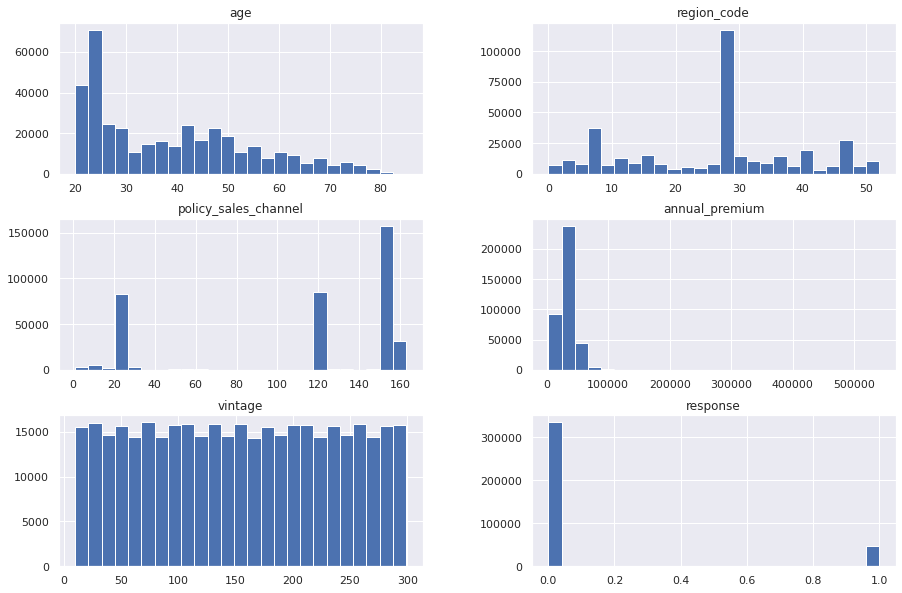

In [136]:
num_att.hist(bins=25);

#### 2.5.1.3 Categorical Attributes
How many IDs in each categorical attribute state?

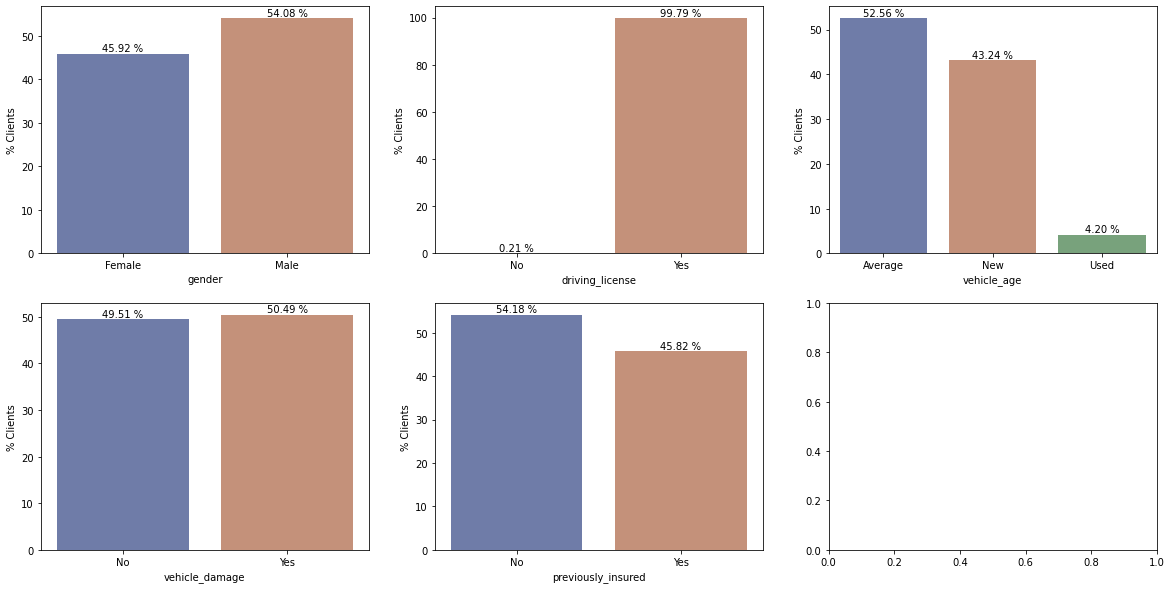

In [115]:
# plot multiple barplot charts

att_list = cat_att.columns.to_list() # get categoric attributes and places its names into a list

# grid and image dimensions
fig, ax = plt.subplots(figsize=(20, 10), nrows = 2, ncols = 3)
#figure, ax = plt.subplots(2,3) # setting grid dimensions

j = 1

for i in att_list:
    df_pct = calculate_pct(df_eda, 'id', i)

    plt.subplot(2,3,j)
    ax= sns.barplot(
    x=i, 
    y='pct', 
    palette = 'dark',
    alpha = 0.6,
    data=df_pct
    )

    #ax.set_xlabel(i)
    ax.set_ylabel('% Clients')

    # plot Y-axis values on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f %%')

    j = j+1

### 2.5.2 Bivariate Analysis
teste das hipóteses

### 2.5.3 Multivariate Analysis

#### 2.5.1.1 Numerical Attributes

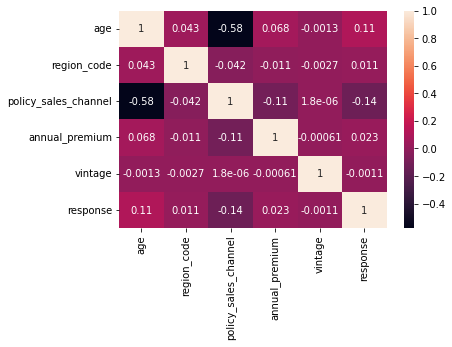

In [116]:
correlation = num_att.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### 2.5.1.2 Categorical Attributes

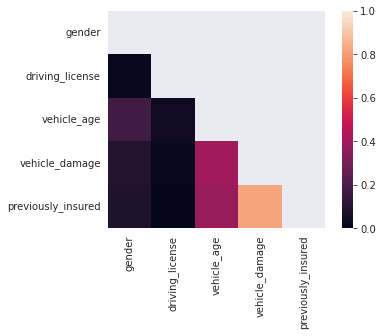

In [117]:
# calculating cramers-v | Useful to determine the strength of a relationship between categorical variables
# source: https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

# 01 - Convert categorical values into numerical values.
# I'll use Label Encoding because all categories here have few values (eg 'Yes' or 'No')
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cat_att.columns:
  data_encoded[i]=label.fit_transform(cat_att[i])


# 02 - Perform Cramer's V test into each category then convert the results to dataframe.
cramers_results= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded: # perform cramer's V test two categories at a time
    cramers =cramers_v(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  cramers_results.append(col) # store test results
  
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns) # convert results (array) to dataframe


# 03 - Plot a heatmap showing Cramer's V test results.
# Preparing a mask to show an empty upper triangle on the heatmap
mask = np.zeros_like(df) # return an array of zeros of same shape and type of df
mask[np.triu_indices_from(mask)] = True # return indices of upper triangle of array and assign 'True' boolean value to this positions

# Plotting heatmap
with sns.axes_style("dark"):
  ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True) # where mask = True data will not be shown.
plt.show();